In [2]:
import pandas as pd
from stockstats import StockDataFrame as Sdf
from pykalman import KalmanFilter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
from sklearn import preprocessing
from sklearn.metrics import accuracy_score,plot_roc_curve
import numpy as np
from nsepy import get_history
from datetime import date
from time import sleep

Defining a function for extracting the daily data from NSEpy for a single stock and adding features to it. The function returns X and y matrix directly 

In [3]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)


def get_data_add_features(NSEsymbol,start,end):
    df = get_history(symbol=NSEsymbol, start=start, end=end)
    
    
    df.reset_index(inplace=True)
    df['Date'] = pd.to_datetime(df['Date'])

    df['day'] = df['Date'].dt.day
    df['week'] = df.Date.dt.isocalendar().week

    df['month'] = df.Date.dt.month
    stock  = Sdf.retype(df)

    df['MACD'] = stock['macd'] - stock['macds']
    df['RSI'] = stock['rsi_14']
    df['adx'] = stock['adx']
    df['VR'] = stock['vr']

    df['returns_yesterday'] = df.close.pct_change()
    df['returns_week'] = df.close.pct_change(5)
    df['returns_month'] = df.close.pct_change(22)
    df['MA_5_diff'] = (df.close.rolling(5).mean() - df.close)/df.close
    df['MA_20_diff'] = (df.close.rolling(20).mean() - df.close)/df.close
    df['MA_50_diff'] = (df.close.rolling(50).mean() - df.close)/df.close
    df['adv20'] = (df.volume.rolling(20).mean() - df.volume)/df.volume
    kf = KalmanFilter(em_vars='all')
    kf.initial_state_mean = df['close'][0]
    (smoothed_state_means, smoothed_state_covariances) = kf.smooth(df['close'])


    df['Kalman_diff'] = (pd.DataFrame(smoothed_state_means.reshape(1,-1)[0]).set_index(df.index) [0] - df['close'])/df['close']

    df['Y'] = np.where(df.close.shift(-1) > df['close'],1,-1)
    df.drop(['symbol','series','trades'],axis=1,inplace=True)
    df = clean_dataset(df)
    X = df.drop(['Y'],axis=1)
    y = df['Y']
    return X,y


We use our function to get training data for TCS stock from 2005 to 2012 and test data from 2012 to 2015 for same stock. Then we train a multinomial classifier model on it with degree 4. Running this cell yields an ROC curve and train/test accuracy


Waiting for 5 seconds to not exceed the throttle limit for data API...


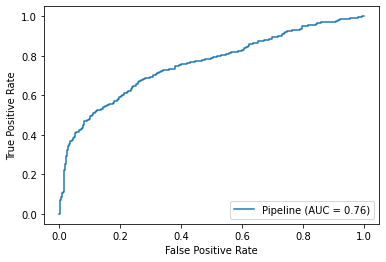

Training Accuracy: 0.7121749408983451
Test Accuracy: 0.6904761904761905


In [4]:
X_train, y_train = get_data_add_features("TCS",date(2005,1,1),date(2012,1,1))
print("Waiting for 5 seconds to not exceed the throttle limit for data API...")
sleep(5) 
X_test, y_test = get_data_add_features("TCS",date(2012,1,3),date(2015,3,30))
scaler = preprocessing.StandardScaler()
degree=4
reg=make_pipeline(PolynomialFeatures(degree),scaler,LogisticRegression(C=0.000001, max_iter=20000,penalty='l2'))

reg.fit(X_train,y_train)


y_pred_train = reg.predict(X_train)
y_pred_test  = reg.predict(X_test)



train_accuracy = accuracy_score(y_pred_train, y_train)
test_accuracy  = accuracy_score(y_pred_test, y_test)

plot_roc_curve(reg, X_test, y_test)
plt.show()
print("Training Accuracy:",train_accuracy)
print("Test Accuracy:",test_accuracy)

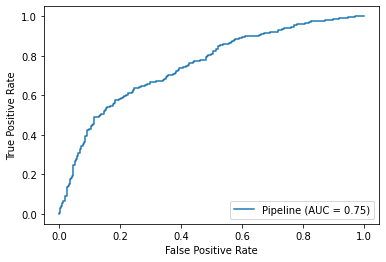

0.6808846761453397


In [5]:
X, y = get_data_add_features("TCS",date(2015,4,1),date(2018,1,1))
y_pred = reg.predict(X)
accuracy  = accuracy_score(y_pred, y)

plot_roc_curve(reg, X, y)
plt.show()
print(accuracy)


Time to make some money!! We see how much we would make if we would have traded according to the decisions given by our model. This method is called backtesting. This gives us a Profit curve of progression of our money with 100,000 as initial investment and compound annual growth rate %(CAGR).

CAGR: It is a measure of a trading strategy's performance. For an idea, Indian fixed deposit, which is a risk free investment, has a CAGR 4.5% per annum. 


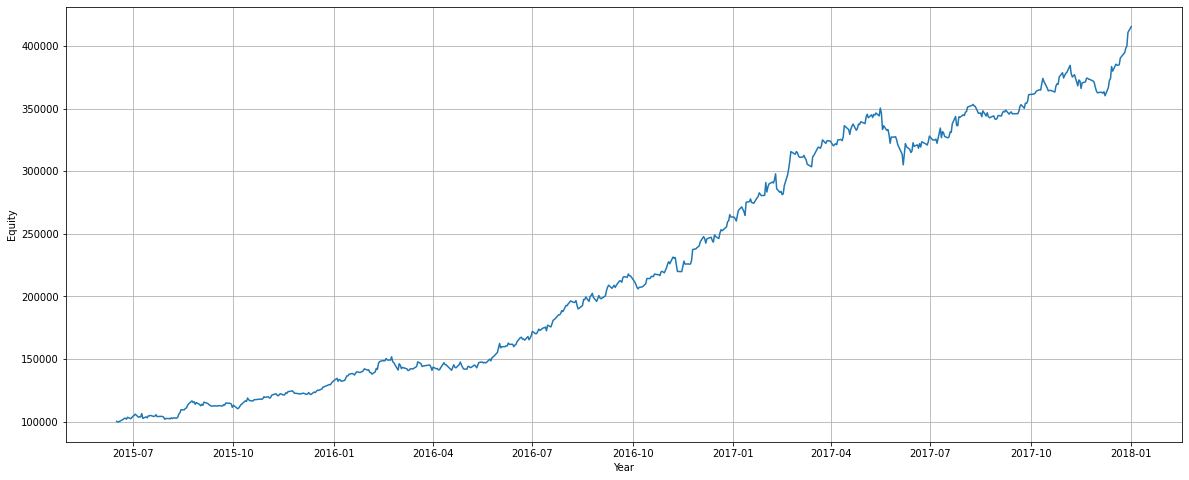

CAGR:  73.43 % per annum


In [6]:
X['Prediction'] = y_pred
X['Prediction'] = X['Prediction'].shift(1)

X['P&L'] = X['Prediction']*(X['close'] - X['open'])/X['open'] - 0.0025
X['P&L'] = 1+ X['P&L'] 

testing_period_years = (X.index[-1] - X.index[0]).days/360
CAGR = ((X['P&L'].cumprod().iloc[-1]/1)**(1/testing_period_years)) - 1 

fig = plt.figure(figsize=(20,8))
ax = fig.gca()
ax.grid()
ax.set_xlabel("Year")
ax.set_ylabel("Equity")
plt.plot(X.index,X['P&L'].cumprod()*100000)
plt.show()
# fig.savefig("Stock_price.png")
print("CAGR: ",round(CAGR*100,2),"% per annum")